In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
import math
import os

In [2]:
records = []
records_chunks = []

phone_name = 'nexus6P'
directory = f'nexus6Pruns'

for file_name in os.listdir(directory):
    
    stuff = re.search(r'log_video_(\d+)fps(\d+)p_([\d_]+)([nmc]{1})', file_name)
    fps, res, mem_state, run_number = int(stuff.group(1)), int(stuff.group(2)), stuff.group(4), float(stuff.group(3).replace('_', '.'))
    
    with open(directory + '/' + file_name) as f:
        lines = list(f.readlines())
#         print(file_name, fps, run_number, len(lines))
        last_record = lines[-1].split('\t')
        if len(last_record) != 11:
            print(f'error parsing {directory}/{file_name}')
        else:
            crashed = int(len(lines) != 45)
            remained_in_moderate = 0
            went_into_critical = 1 if mem_state == 'm' and crashed == 0 else 0
            remained_in_critical = 1 if mem_state == 'c' and crashed == 0 else 0
            situation = 'Remained in Normal'
            if crashed:
                situation = 'Crashed'
            elif went_into_critical:
                situation = 'Went into Critical'
            elif remained_in_critical:
                situation = 'Remained in Critical'
            records.append([phone_name, float(last_record[0])*1000, mem_state, res, fps, int(run_number), int(last_record[-3]), int(last_record[-2]), crashed, len(lines), float(last_record[-4]), float(last_record[-9]), remained_in_moderate, went_into_critical, remained_in_critical, situation])
            
            count = 0
            for line in [line.split('\t') for line in lines]:
#                 print(line)
                if len(line) > 1:
                    records_chunks.append([phone_name, float(line[0])*1000, mem_state, res, fps, int(run_number), count,
                                    int(line[-3]),
                                   int(line[-2]),
                                   crashed,
                                   len(lines),
                                    float(line[-4]), float(line[-9]), float(line[-1]),
                                    remained_in_moderate, went_into_critical, remained_in_critical, situation])
                    count += 1
            
raw_df = pd.DataFrame(records, columns=['Phone', 'timestamp', 'Mem. State', 'Resolution', 'FPS', 'Run No.', 'Dropped Frames', 'Total Frames', 'Crashed', 'Chunks', 'Time Elapsed (s)', 'Buffer (s)', 'Remained in Moderate', 'Went into Critical', 'Remained in Critical', 'Situation'])
raw_df_chunks = pd.DataFrame(records_chunks, columns=['Phone', 'timestamp', 'Mem. State', 'Resolution', 'FPS', 'Run No.', 'Chunk No.', 'Dropped Frames', 'Total Frames', 'Crashed', 'Chunks', 'Time Elapsed (s)', 'Buffer (s)', 'Rendered FPS', 'Remained in Moderate', 'Went into Critical', 'Remained in Critical', 'Situation'])

In [3]:
# normal df
df = raw_df.sort_values(['Phone', 'Resolution', 'FPS', 'Mem. State', 'Run No.'])
df['%age Frames Dropped'] = (df['Dropped Frames']/df['Total Frames'])*100

# df chunks
df_chunks = raw_df_chunks.sort_values(['Phone', 'Resolution', 'FPS', 'Mem. State', 'Run No.', 'Chunk No.'])
df_chunks['%age Frames Dropped'] = (df_chunks['Dropped Frames']/df_chunks['Total Frames'])*100
df_chunks['Inst. Frame Drop %age'] = (df_chunks['Rendered FPS']/df_chunks['FPS'])*100

In [4]:
def change_mem_state_label(label):
    if label == 'n':
        return 'normal'
    elif label == 'm':
        return 'moderate'
    elif label == 'c':
        return 'critical'
    else:
        return label

In [5]:
df['Mem. State'] = df['Mem. State'].apply(change_mem_state_label)
df_chunks['Mem. State'] = df_chunks['Mem. State'].apply(change_mem_state_label)

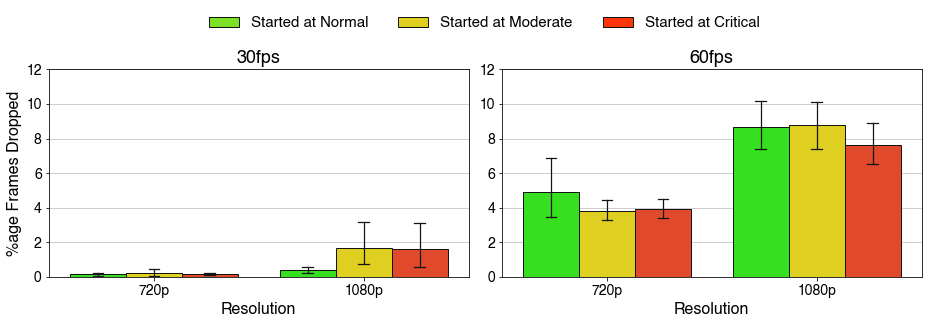

In [6]:
def plot_frames_dropped(ax, fps):
    
    sns.barplot(ax=ax, data=df.loc[df['FPS'] == fps], x='Resolution', y='%age Frames Dropped',
                hue='Mem. State',
                hue_order=['normal', 'moderate', 'critical'], 
                palette={'normal': '#1eff00', 'moderate': '#ffea00', 'critical': '#ff350a'},
                edgecolor='#141414', linewidth=1,
                capsize=.05, errwidth=1.25, errcolor='#141414')
                

    ax.set_title(f'{fps}fps', fontsize=18)
    ax.set_xlabel('Resolution', fontsize=16)
    if fps==60:
        ax.set_ylabel('', fontsize=16)
    else:
        ax.set_ylabel('%age Frames Dropped', fontsize=16)
  

    if fps == 30:
        ax.set_yticks(np.arange(0,13,2))
        ax.set_yticklabels(np.arange(0,13,2), rotation=0, fontsize=14)
    else:
        ax.set_yticks(np.arange(0,13,2))
        ax.set_yticklabels(np.arange(0,13,2), rotation=0, fontsize=14)

    ax.set_xticklabels(['720p', '1080p'], rotation=0, fontsize=14)

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')

    ax.get_legend().remove()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

plot_frames_dropped(ax1, 30)
plot_frames_dropped(ax2, 60)

plt.tight_layout()

p1 = mpatches.Patch(color='#7BE026', label='Started at Normal', ec='#141414', lw=1)
p2 = mpatches.Patch(color='#DFCF21', label='Started at Moderate', ec='#141414', lw=1)
p3 = mpatches.Patch(color='#ff350a', label='Started at Critical', ec='#141414', lw=1)

ax1.legend(handles=[p1,p2,p3], bbox_to_anchor=(0.36, 1.3), loc=2, fontsize=15, borderaxespad=0., borderpad=0.6, ncol=3, frameon=False)

plt.savefig(f"./nexus6P.jpg", format="jpg" , dpi=300, bbox_inches='tight', pad_inches=0.2)